### Motivation:

In previous data addition experiments, we found that the mean label value for the train set was not a good proxy for the mean output value of the model which it was used to train on. This suggests that the models are not well calibrated.
1. Observation: in these experiments, the train and test sets are not identically distributed, so we shouldn't expect the mean of the predictions to match the mean of the train set (in a perfect model). Follow up: however, if the mean of the predictions also not close to the mean of the test set, then what is wrong with the model?

In this notebook, we will calibrate model outputs for the eICU dataset, and focus on the following questions and observations:
1. How does the mean consistency of the train set affect the model performance after all models are calibrated?

## Setup

Get pre-calibration results and information

In [4]:
import os
import json
import glob
import pickle
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import precision_recall_curve, roc_auc_score
from scipy.stats import pearsonr
from calibrator import IsotonicCalibrator, compute_calibration_error

import warnings
warnings.filterwarnings('ignore')

In [5]:
# CONSTANTS
model = "LogisticRegression"
metric = "ACC_TEST"
n = 1000

base_log_dir = Path(f"../../yaib_logs/eicu/Mortality24/{model}/")

map_race = {0: 'asian', 
            1: 'black',
            2: 'other',
            3: 'white'}

map_gender = {0: 'Female', 1: 'Male'}

map_attribute = {'race0': 'asian',
                 'race1': 'black',
                 'race2': 'other',
                 'race3': 'white',
                 'gender0': 'Female',
                 'gender1': 'Male'}

reverse_map_attribute = {'asian': 'race0',
                         'black': 'race1',
                         'other': 'race2',
                         'white': 'race3',
                         'Female': 'gender0',
                         'Male': 'gender1'}

format_metric = {'ACC': 'Test Accuracy',
                 'ACC_TEST': 'Test Accuracy',
                 'AUC_TEST': 'Test AUC',
                 'AUC': 'Test AUC'}

hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

In [6]:
# read hospital patient demographics

df_race = pd.read_csv('demo_data.csv')

# read patient data
df = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/sta.parquet', engine='pyarrow')

patient_hospital = pd.read_csv('../../YAIB-cohorts/data/mortality24/eicu/patient_hospital.csv')
patient_hospital = patient_hospital.rename(columns={'patientunitstayid': 'stay_id'})

df = df.merge(patient_hospital[['stay_id', 'hospitalid']], on='stay_id', how='left')
df = df.rename(columns={'hospitalid': 'hosp_id'})

# add outcome data
df_outc = pd.read_parquet('../../YAIB-cohorts/data/mortality24/eicu/outc.parquet', engine='pyarrow')

df = df.merge(df_outc, on='stay_id')

In [7]:
# read base results
hospital_data = {}
for i in range(len(hospital_ids)):
    hospital_data[hospital_ids[i]] = {}

base_avg = np.load(f"../results/base/{model}-n{n}-avg.npz", allow_pickle=True)
metrics = list(base_avg.files)

for i, hos in enumerate(hospital_ids):
    hospital_data[hos]["AUC_TEST"] = base_avg["AUC_TEST"].item()[hos]
    hospital_data[hos]["ACC_TEST"] = base_avg["ACC_TEST"].item()[hos]
    
    for met in ["ACC_TEST", "AUC_TEST"]:
        min_auc = float('inf')
        min_metric = None
        
        for eth in range(1,4):
            auc_value = base_avg[f'race{eth}_{met}'].item()[hos]
            if auc_value < min_auc:
                min_auc = auc_value
                min_metric = map_race[eth]
            hospital_data[hospital_ids[i]][f'{map_attribute[f"race{eth}"]}_{met}'] = auc_value
        
        hospital_data[hospital_ids[i]][f"worst_{met}_subgroup"] = min_metric.split("_")[0]

In [8]:
# read results from data addition experiments

add_data_avg = np.load(f"../results/add_data/{model}-n{n}-avg.npz", allow_pickle=True)
add_data_std = np.load(f"../results/add_data/{model}-n{n}-std.npz", allow_pickle=True)
add_data_ci = np.load(f"../results/add_data/{model}-n{n}-ci.npz", allow_pickle=True)

auc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*AUC.*').match(metric)]
bacc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*BACC.*').match(metric)]
acc_metrics = [metric for metric in add_data_avg.files if re.compile(r'.*ACC.*').match(metric)]
acc_metrics = list(set(acc_metrics) - set(bacc_metrics))

base_columns = ['hosp_id', 'count', 'AUC', 'ACC']

addition_data = {} # {metric: results_arr}

# overall metric
addition_data[metric] = add_data_avg[metric]
addition_data[f"{metric}_diff"] = add_data_avg[metric] - [hospital_data[hos][metric] for hos in hospital_ids]
addition_data[f"{metric}_ci"] = (add_data_ci[metric][1] - add_data_ci[metric][0]) / 2

base_data = {}
# subgroup metrics
for i, subgroup in map_race.items():
    if i == 0:
        continue # skip asian
    
    add_data = add_data_avg[f"race{i}_{metric}"] # 12 x 12 arr
    add_ci = add_data_ci[f"race{i}_{metric}"] # 2 x 12 x 12 arr
    base_data[subgroup] = [hospital_data[hos][f"{subgroup}_{metric}"] for hos in hospital_ids] # 12 x 1 arr
    
    addition_data[f"race{i}_{metric}"] = add_data
    addition_data[f"race{i}_{metric}_diff"] = add_data - base_data[subgroup]  
    addition_data[f"race{i}_{metric}_ci"] = (add_ci[1] - add_ci[0]) / 2

## Calibrating the Models

Models should be group calibrated across ethnic groups.

In [9]:
# for each add_data experiment
changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}  
hist_changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
base_calibration_error = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
heat_changes = []

for i, test_hos in enumerate(hospital_ids):
    for j, train_hos in enumerate(hospital_ids):
        if test_hos == train_hos:
            dir_str = f"train-test{test_hos}-n{n*2}"
        else:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
        exp_dir = os.path.join(base_log_dir, dir_str)
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]

        # Initialize lists to store results across folds and repetitions
        exp_changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
        exp_hist_changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
        exp_heat_changes = []
        base_changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

        # Iterate through all repetitions and folds
        for rep in range(5):  # 5 repetitions
            for fold in range(5):  # 5 folds
                try:
                    patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))
                except:
                    print(f"no patient results for {dir_str}")

                test_ids = patient_results['test_ids']
                test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
                
                test_labels = patient_results['true_labels']
                test_probs = patient_results['predictions']
                test_preds = patient_results['pred_labels']
                
                val_ids = patient_results['val_ids']
                val_races = patient_results['val_races']
                val_probs = patient_results['val_predictions']
                val_labels = patient_results['val_true_labels']
                val_preds = patient_results['val_pred_labels']
                thresh = patient_results['thresh']
                
                val_hosps = pd.DataFrame({'stay_id':val_ids}).merge(df, on='stay_id')['hosp_id'].values
                test_hosps = pd.DataFrame({'stay_id':test_ids}).merge(df, on='stay_id')['hosp_id'].values
                
                assert np.all(test_hosps == test_hos)
                
                # group by subgroup
                for i, subgroup in map_race.items():
                    if i != 0:
                        val_subg_idx = np.where((val_races == i) & (val_hosps == test_hos))[0]
                        test_subg_idx = np.where(test_races == subgroup)[0]
                        
                        if np.unique(val_labels[val_subg_idx]).size > 1 and len(val_subg_idx) > 20:
                            calibrator = IsotonicCalibrator()
                            calibrator.calibrate(val_probs[val_subg_idx], val_labels[val_subg_idx])
                            
                            # Compute ECE
                            base_ece = compute_calibration_error(test_labels[test_subg_idx], test_probs[test_subg_idx], n_bins=50)
                            
                            test_cali_probs = calibrator.transform(test_probs[test_subg_idx])
                            test_cali_labels = test_cali_probs >= 0.5
                            
                            # Compute post-calibration ECE and GCE
                            post_ece = compute_calibration_error(test_labels[test_subg_idx], test_cali_probs, n_bins=50)

                            train_labels = pd.DataFrame({'stay_id': patient_results['train_ids']}).merge(df, on='stay_id')['label'].values
                            train_mean_consistency = abs(np.mean(train_labels) - np.mean(test_labels[test_subg_idx]))
                            
                            # get post-calibration accuracy
                            subg_cali_acc = np.mean(test_cali_labels == test_labels[test_subg_idx])
                            subg_base_acc = np.mean(test_preds[test_subg_idx] == test_labels[test_subg_idx])
                            
                            # Store ECE changes
                            exp_changes[subgroup].append((train_mean_consistency, post_ece - base_ece))
                            exp_heat_changes.append((train_mean_consistency, post_ece, len(val_subg_idx)))
                            exp_hist_changes[subgroup].append(post_ece - base_ece)

                            base_changes[subgroup].append((subg_base_acc, base_ece))

        # Average results across all folds and repetitions
        for subgroup in exp_changes.keys():
            if exp_changes[subgroup] and len(exp_changes[subgroup]) == 25:  # If we have any results for this subgroup
                # ECE averaging
                avg_train_consistency = np.mean([x[0] for x in exp_changes[subgroup]])
                avg_ece_change = np.mean([x[1] for x in exp_changes[subgroup]])
                changes[subgroup].append((avg_train_consistency, avg_ece_change))
                
                if exp_hist_changes[subgroup]:
                    hist_changes[subgroup].append(np.mean(exp_hist_changes[subgroup]))

            base_calibration_error[subgroup].append((np.mean([item[0] for item in base_changes[subgroup]]), np.mean([item[1] for item in base_changes[subgroup]])))

        if exp_heat_changes and len(exp_heat_changes) == 25:  # If we have any heat changes
            avg_train_consistency = np.mean([x[0] for x in exp_heat_changes])
            avg_ece_change = np.mean([x[1] for x in exp_heat_changes])
            avg_val_size = np.mean([x[2] for x in exp_heat_changes])
            heat_changes.append((avg_train_consistency, avg_ece_change, avg_val_size))

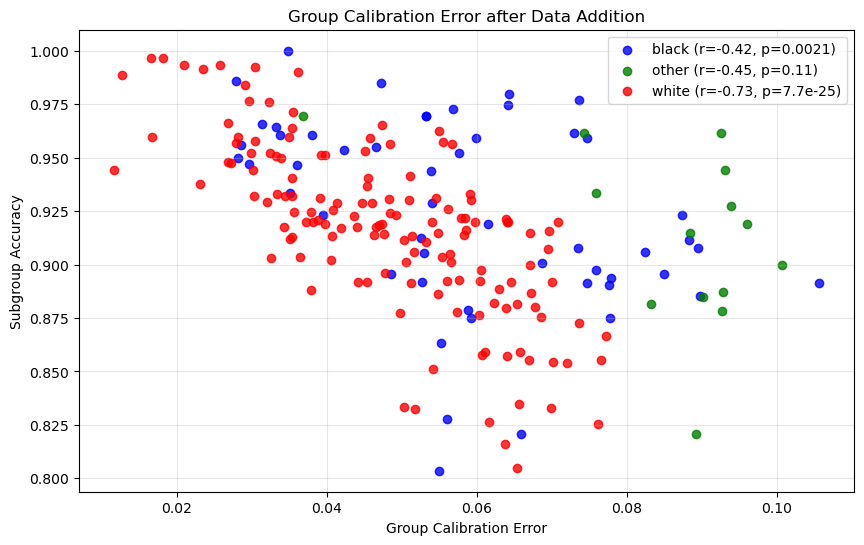

In [19]:
# VISUALIZATION: Calibration Error pre-calibration post-addition
# scatter plot of CHANGES colored by subgroup

# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}
for subgroup, data in base_calibration_error.items():
    data = [(a, b) for a, b in data if not (np.isnan(a) or np.isnan(b))]

    if len(data) > 0:
        x_group = [point[0] for point in data]
        y_group = [point[1] for point in data]
        
        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr(x_group, y_group)
        label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})"
        
        # Add scatter points for the subgroup
        plt.scatter(y_group, x_group, 
                   label=label, 
                   color=colors[subgroup], 
                   alpha=0.8)

plt.title('Group Calibration Error after Data Addition')
plt.xlabel('Group Calibration Error')
plt.ylabel('Subgroup Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

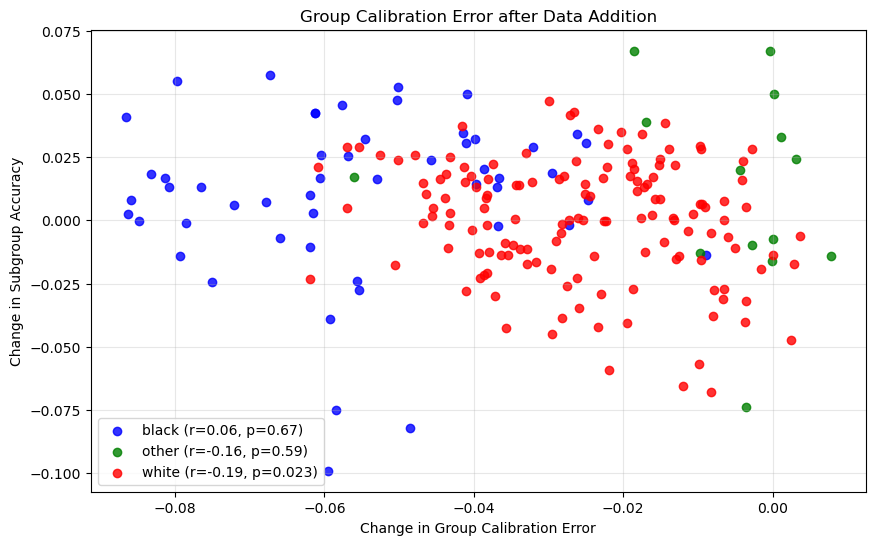

In [21]:
# get pre-addition calibration error
pre_addition_calibration_error = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

for i, hos in enumerate(hospital_ids):
    dir_str = f"train-test{test_hos}-n{n}"

    ece_vals = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}

    # Iterate through all repetitions and folds
    for rep in range(5):  # 5 repetitions
        for fold in range(5):  # 5 folds
            try:
                patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))
            except:
                print(f"no patient results for {dir_str}")

            test_ids = patient_results['test_ids']
            test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
            
            test_labels = patient_results['true_labels']
            test_probs = patient_results['predictions']
            test_preds = patient_results['pred_labels']

            for j, subgroup in map_race.items(): 
                if j != 0:
                    test_subg_idx = np.where(test_races == subgroup)[0]          
                    
                    ece = compute_calibration_error(test_labels[test_subg_idx], test_probs[test_subg_idx], n_bins=50)
                    ece_vals[subgroup].append(ece)
    
    for subgroup in ece_vals.keys():
        pre_addition_calibration_error[subgroup].append(np.mean(ece_vals[subgroup]))

# VISUALIZATION: Calibration Error pre-calibration post-addition
# scatter plot of CHANGES colored by subgroup

# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

for subgroup, data in base_calibration_error.items():

    if len(data) > 0:
        x_group = [point[0] - base_data[subgroup][i//12] for i, point in enumerate(data)]
        y_group = [point[1] - pre_addition_calibration_error[subgroup][i//12] for i, point in enumerate(data)]
        
        data = [(x, y) for x, y in zip(x_group, y_group) if not (np.isnan(x) or np.isnan(y))]

        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr([pair[0] for pair in data], [pair[1] for pair in data])
        
        # Add scatter points for the subgroup
        plt.scatter(y_group, x_group, 
                   label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})", 
                   color=colors[subgroup], 
                   alpha=0.8)

plt.title('Group Calibration Error after Data Addition')
plt.xlabel('Change in Group Calibration Error')
plt.ylabel('Change in Subgroup Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

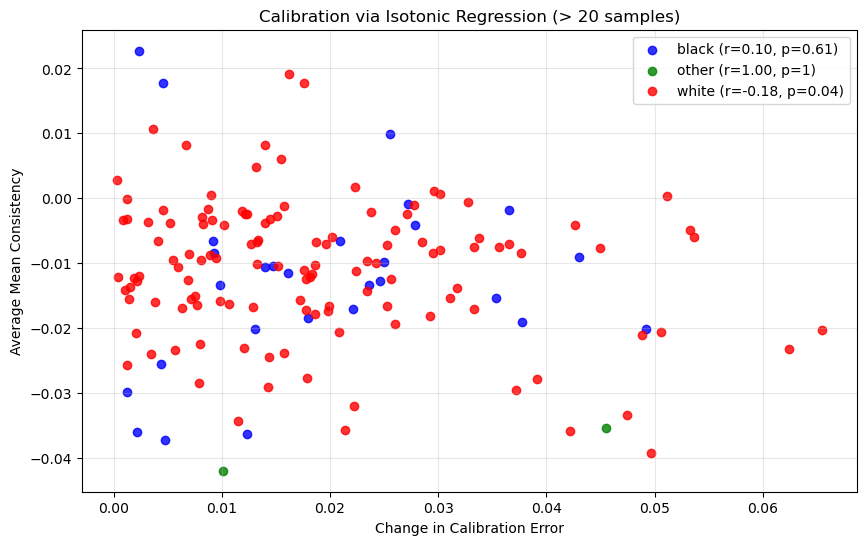

In [33]:
# scatter plot of CHANGES colored by subgroup

# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}
for subgroup, data in changes.items():
    if len(data) > 0:  # Only plot if we have data for this subgroup
        x_group = [point[0] for point in data]
        y_group = [point[1] for point in data]
        
        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr(x_group, y_group)
        
        # Add scatter points for the subgroup
        plt.scatter(x_group, y_group, 
                   label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})", 
                   color=colors[subgroup], 
                   alpha=0.8)

plt.title('Calibration via Isotonic Regression (> 20 samples)')
plt.xlabel('Change in Calibration Error')
plt.ylabel('Average Mean Consistency')
plt.legend()
plt.grid(True, alpha=0.3)

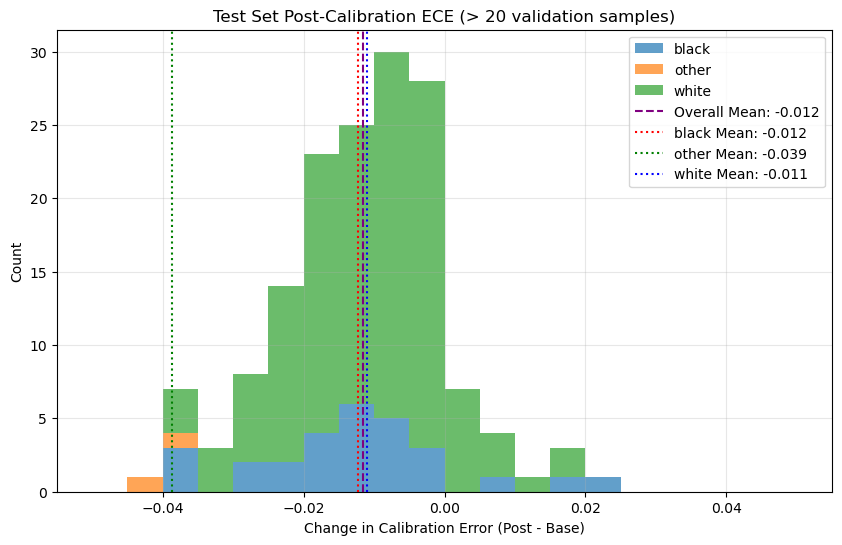

In [28]:
# stacked histogram of HIST_CHANGES colored by subgroup

# Create stacked histogram
plt.figure(figsize=(10, 6))

# Define bins for the histogram
bins = np.linspace(-0.05, 0.05, 21)  # Adjust range as needed

# Create stacked histogram
hist_data = []
labels = []
for subgroup in changes.keys():
    if len(changes[subgroup]) > 0:
        hist_data.append(hist_changes[subgroup])
        labels.append(subgroup)

plt.hist(hist_data, bins=bins, label=labels, stacked=True, alpha=0.7)

# Calculate and plot means
all_changes = [item for sublist in hist_data for item in sublist]  # Flatten the list
overall_mean = np.mean(all_changes)
plt.axvline(x=overall_mean, color='purple', linestyle='--', label=f'Overall Mean: {overall_mean:.3f}')

# Plot subgroup means
mean_colors = ['red', 'green', 'blue']  # Different colors for each subgroup mean
for i, subgroup in enumerate(labels):
    subgroup_mean = np.mean(hist_data[i])
    plt.axvline(x=subgroup_mean, color=mean_colors[i], 
                linestyle=':', label=f'{subgroup} Mean: {subgroup_mean:.3f}')

plt.xlabel('Change in Calibration Error (Post - Base)')
plt.ylabel('Count')
plt.title('Test Set Post-Calibration ECE (> 20 validation samples)')
plt.legend()
plt.grid(True, alpha=0.3)

### What do we want to show by calibrating the models?

Originally, we found that the train set label mean was not a good proxy for the model prediction mean. This indicated that the models were miscalibrated. 

Why is that bad? Earlier findings showed that the mean consistency of the model mean and the test set mean was highly correlated with subgroup performance. However, this requires knowing the model mean via training (which is infeasible to do for all combinations of training data). We wanted to find a proxy for the model mean but the mean of the train set was not helpful (due to miscalibration).

Solution: calibrate the models. 
1. Is the miscalibration caused by inconsistent data?
2. Is miscalibration (a post-processing technique) rendered useless if the training data is too bad (inconsistent) to begin with?


**Calibrating over the entire validation set**

Procedure: create calibrated probability bins using the entire validation set (2 hospitals combined), then calibrate test set (one subgroup) using these bins.

1. How does this relate to mean consistency?
2. Why is calibration causing subgroup performance decreases among certain subgroups?


**Calibrating each subgroup (group calibration)**

Procedure: create calibrated probability bins using all samples belonging to a subgroup of the validation set, then calibrate the test set (one subgroup) using its corresponding bins.

### Back to Mean Consistency

In this section, we want to see if calibrating the models now makes the train set mean a viable proxy for model mean.

If so, then we should see:
- correlation between ((|subgroup train set mean - subgroup mean|) - subgroup base mean discrepancy) and (change in post-calibration subgroup accuracy)

In [ ]:
base_mean_discs = {hos: {} for hos in hospital_ids}

for i, test_hos in enumerate(hospital_ids):
    
    # get base mean discrepancy
    dir_str = f"train-test{test_hos}-n{n}"
    exp_dir = os.path.join(base_log_dir, dir_str)
    
    # get directory for most recent run
    files = os.listdir(exp_dir)
    files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
    paths = [os.path.join(exp_dir, basename) for basename in files]
    target_dir = max(paths, key=os.path.getctime)
    
    subg_means = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
    for rep in range(5):
        for fold in range(5):
            filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
            data = np.load(filename)
            
            try:
                races = pd.DataFrame({'stay_id': data['patient_ids']}).merge(df, on='stay_id')['ethnic'].values
            except:
                races = pd.DataFrame({'stay_id': data['train_ids']}).merge(df, on='stay_id')['ethnic'].values
            
            test_races = data["test_races"]
            pred_label = data["pred_labels"] # test predictions
            true_labels = data["true_labels"] # test labels
            
            for i, subgroup in map_race.items():
                if i != 0:
                    subg_idx = np.where(test_races == subgroup)[0]
                    subg_means[subgroup].append(abs(np.mean(true_labels[subg_idx]) - np.mean(pred_label[subg_idx])))
    
    base_mean_discs[test_hos] = {subgroup: np.mean(subg_means[subgroup]) for subgroup in subg_means.keys()}

In [ ]:
# for each add_data experiment
changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}  # Initialize dictionary for each subgroup

for i, test_hos in enumerate(hospital_ids):    
    for j, train_hos in enumerate(hospital_ids):
        
        if test_hos == train_hos:
            dir_str = f"train-test{test_hos}-n{n*2}"
        else:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
        exp_dir = os.path.join(base_log_dir, dir_str)
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]

        patient_results = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))

        test_ids = patient_results['test_ids']
        test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
        
        test_labels = patient_results['true_labels']
        test_probs = patient_results['predictions']
        test_preds = patient_results['pred_labels']
        
        val_ids = patient_results['val_ids']
        val_races = patient_results['val_races']
        val_probs = patient_results['val_predictions']
        val_labels = patient_results['val_true_labels']
        val_preds = patient_results['val_pred_labels']
        thresh = patient_results['thresh']
        
        train_demo = pd.DataFrame({'stay_id': patient_results['train_ids']}).merge(df, on='stay_id')
        train_labels = train_demo['label'].values
        train_races = train_demo['ethnic'].values
        train_hosps = train_demo['hosp_id'].values
        
        # group by subgroup
        for i, subgroup in map_race.items():
            if i != 0:
                val_subg_idx = np.where((val_races == i))[0]
                test_subg_idx = np.where(test_races == subgroup)[0]
                
                if np.unique(val_labels[val_subg_idx]).size > 1 and len(val_subg_idx) > 20: # both positive and negative samples present
                    calibrator = IsotonicCalibrator()
                    calibrator.calibrate(val_probs[val_subg_idx], val_labels[val_subg_idx])
                    
                    train_set_mean = np.mean(train_labels[np.where(train_races == subgroup)])
                    true_mean = np.mean(test_labels[test_subg_idx])
                    
                    post_mean_disc = abs(train_set_mean - true_mean)
                    
                    base_mask = np.where((train_hosps == test_hos))
                    base_mean_disc = abs(np.mean(train_labels[base_mask]) - true_mean)
                    # base_mean_disc = base_mean_discs[test_hos][subgroup]
                    
                    # calibrate the test set
                    test_cali_probs = calibrator.transform(test_probs[test_subg_idx])
                    test_cali_labels = test_cali_probs >= 0.5 # TODO: re-tune threshold post-calibration

                    # get post-calibration accuracy
                    subg_cali_acc = np.mean(test_cali_labels == test_labels[test_subg_idx])
                    subg_base_acc = np.mean(test_preds[test_subg_idx] == test_labels[test_subg_idx])

                    # estimate mean consistency of the train set
                    train_labels = pd.DataFrame({'stay_id': patient_results['train_ids']}).merge(df, on='stay_id')['label'].values
                    train_mean_consistency = abs(np.mean(train_labels) - np.mean(test_labels[test_subg_idx]))
                    
                    # Store data by subgroup
                    changes[subgroup].append((post_mean_disc - base_mean_disc, subg_cali_acc - subg_base_acc))

In [ ]:
# for each add_data experiment
changes = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}  # Initialize dictionary for each subgroup
base_mean_discs = {hos: {} for hos in hospital_ids}

for i, test_hos in enumerate(hospital_ids):   
    
    # get base mean discrepancy
    dir_str = f"train-test{test_hos}-n{n}"
    exp_dir = os.path.join(base_log_dir, dir_str)
    
    # get directory for most recent run
    files = os.listdir(exp_dir)
    files = [name for name in files if os.path.isdir(os.path.join(exp_dir, name)) and not name.startswith('.')] # folders only     
    paths = [os.path.join(exp_dir, basename) for basename in files]
    target_dir = max(paths, key=os.path.getctime)
    
    subg_means = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
    subg_true_means = {subgroup: [] for subgroup in map_race.values() if subgroup != 'asian'}
    for rep in range(5):
        for fold in range(5):
            filename = os.path.join(target_dir, f'repetition_{rep}', f'fold_{fold}', 'patient_results.npz')
            data = np.load(filename)
            
            try:
                races = pd.DataFrame({'stay_id': data['patient_ids']}).merge(df, on='stay_id')['ethnic'].values
            except:
                races = pd.DataFrame({'stay_id': data['test_ids']}).merge(df, on='stay_id')['ethnic'].values
            pred_label = data["pred_labels"]
            true_labels = data["true_labels"]
            
            for i, subgroup in map_race.items():
                if i != 0:
                    subg_idx = np.where(races == subgroup)[0]
                    subg_means[subgroup].append(abs(np.mean(true_labels[subg_idx]) - np.mean(pred_label[subg_idx])))
                    subg_true_means[subgroup].append(np.mean(true_labels[subg_idx]))
    
    base_mean_discs[test_hos] = {subgroup: np.mean(subg_means[subgroup]) for subgroup in subg_means.keys()}
     
    for j, train_hos in enumerate(hospital_ids):
        
        if test_hos == train_hos:
            dir_str = f"train-test{test_hos}-n{n*2}"
        else:
            dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
        exp_dir = os.path.join(base_log_dir, dir_str)
        files = os.listdir(exp_dir)
        files.sort()
        datetime = files[-1]

        patient_results = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))

        test_ids = patient_results['test_ids']
        test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
        
        test_labels = patient_results['true_labels']
        test_probs = patient_results['predictions']
        test_preds = patient_results['pred_labels']
        
        val_ids = patient_results['val_ids']
        val_races = patient_results['val_races']
        val_probs = patient_results['val_predictions']
        val_labels = patient_results['val_true_labels']
        val_preds = patient_results['val_pred_labels']
        thresh = patient_results['thresh']
        
        train_demo = pd.DataFrame({'stay_id': patient_results['train_ids']}).merge(df, on='stay_id')
        train_labels = train_demo['label'].values
        train_races = train_demo['ethnic'].values
        train_hosps = train_demo['hosp_id'].values
        
        # group by subgroup
        for i, subgroup in map_race.items():
            if i != 0:
                val_subg_idx = np.where((val_races == i))[0]
                test_subg_idx = np.where(test_races == subgroup)[0]
                
                if np.unique(val_labels[val_subg_idx]).size > 1 and len(val_subg_idx) > 20: # both positive and negative samples present
                    calibrator = IsotonicCalibrator()
                    calibrator.calibrate(val_probs[val_subg_idx], val_labels[val_subg_idx])
                    
                    train_set_mean = np.mean(train_labels[np.where(train_races == subgroup)])
                    true_mean = np.mean(test_labels[test_subg_idx])
                    
                    post_mean_disc = abs(train_set_mean - np.mean(subg_true_means[subgroup]))
                    
                    base_mask = np.where((train_hosps == test_hos))
                    base_mean_disc = abs(np.mean(train_labels[base_mask]) - np.mean(subg_true_means[subgroup]))
                    # base_mean_disc = base_mean_discs[test_hos][subgroup]
                    
                    # calibrate the test set
                    test_cali_probs = calibrator.transform(test_probs[test_subg_idx])
                    test_cali_labels = test_cali_probs >= 0.5 # TODO: re-tune threshold post-calibration

                    # get post-calibration accuracy
                    subg_cali_acc = np.mean(test_cali_labels == test_labels[test_subg_idx])
                    subg_base_acc = np.mean(test_preds[test_subg_idx] == test_labels[test_subg_idx])

                    # estimate mean consistency of the train set
                    train_labels = pd.DataFrame({'stay_id': patient_results['train_ids']}).merge(df, on='stay_id')['label'].values
                    train_mean_consistency = abs(np.mean(train_labels) - np.mean(test_labels[test_subg_idx]))
                    
                    # Store data by subgroup
                    changes[subgroup].append((post_mean_disc - base_mean_disc, subg_cali_acc - subg_base_acc))

In [ ]:
# scatter plot of CHANGES colored by subgroup

# Scatter plot with different colors for each subgroup
plt.figure(figsize=(10, 6))

colors = {'black': 'blue', 'other': 'green', 'white': 'red'}
for subgroup, data in changes.items():
    if len(data) > 0:  # Only plot if we have data for this subgroup
        x_group = [point[0] for point in data]
        y_group = [point[1] for point in data]
        
        # Compute correlation coefficient and p-value for this subgroup
        corr_coef, p_val = pearsonr(x_group, y_group)
        
        # Add scatter points for the subgroup
        plt.scatter(x_group, y_group, 
                   label=f"{subgroup} (r={corr_coef:.2f}, p={p_val:.2g})", 
                   color=colors[subgroup], 
                   alpha=0.8)

plt.title('Post-Calibration Mean Consistency (via Isotonic Regression, > 20 samples)')
plt.xlabel('Change in Mean Discrepancy')
plt.ylabel('Change in Subgroup Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

this figure plots

$$|\text{train set subgroup mean after addition} - \text{true subgroup mean}| - |\text{base model subgroup mean} - \text{true subgroup mean}|$$

against change in subgroup accuracy

### Comparing data- and post-processing interventions

Before calibration, log:
1. Best performing hospital for data addition
2. Worst performing hospital for data addition
3. Median performing hospital for data addition
4. Base performance (no data addition)
For each test hospital

Then, on each of these logged hospitals, calibrate the model and log the new change in accuracy. Observe:
1. Comparative difference in subgroup accuracy before and after addition
2. Comparative difference between best performing without calibration (addition-only) with post-calibration performance of worst performing hospital.

To visualize:
For each test hospital, three tables (one for each subgroup).


In [ ]:
# Initialize dictionaries to store results
best_hospitals = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}
median_hospitals = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}
worst_hospitals = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}

# For each subgroup and test hospital
for i, subgroup in map_race.items():
    if i == 0:  # Skip asian
        continue
        
    diff_results = addition_data[f'race{i}_{metric}_diff']
    
    for j, test_hos in enumerate(hospital_ids):
        # Get the performance values for this test hospital
        performances = diff_results[:, j]  # Row j corresponds to test_hos
        
        # Check validation data availability for each training hospital
        valid_hospitals = []
        valid_performances = []
        
        for train_idx, train_hos in enumerate(hospital_ids):
            # Check if this hospital has sufficient validation data
            if test_hos == train_hos:
                dir_str = f"train-test{test_hos}-n{n*2}"
            else:
                dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
            exp_dir = os.path.join(base_log_dir, dir_str)
            files = os.listdir(exp_dir)
            files.sort()
            datetime = files[-1]
            
            try:
                patient_results = np.load(os.path.join(exp_dir, datetime, 'repetition_0/fold_0/patient_results.npz'))
                val_races = patient_results['val_races']
                val_labels = patient_results['val_true_labels']
                val_subg_idx = np.where((val_races == i))[0]
                
                if np.unique(val_labels[val_subg_idx]).size > 1:
                    valid_hospitals.append(train_hos)
                    valid_performances.append(performances[train_idx])
            except:
                continue
        
        # Only proceed if we have at least 3 valid hospitals
        if len(valid_hospitals) >= 3:
            # Find indices of best, median, and worst performing hospitals among valid ones
            valid_performances = np.array(valid_performances)
            valid_hospitals = np.array(valid_hospitals)
            
            best_idx = np.argmax(valid_performances)
            worst_idx = np.argmin(valid_performances)
            
            # For median, we need to handle even number of hospitals
            sorted_indices = np.argsort(valid_performances)
            median_idx = sorted_indices[len(sorted_indices)//2]
            
            best_ci = addition_data[f"race{i}_{metric}_ci"][best_idx, j]
            median_ci = addition_data[f"race{i}_{metric}_ci"][median_idx, j]
            worst_ci = addition_data[f"race{i}_{metric}_ci"][worst_idx, j]
            
            # Store the hospital IDs and their performance values as tuples
            best_hospitals[subgroup][test_hos] = (valid_hospitals[best_idx], valid_performances[best_idx], best_ci)
            median_hospitals[subgroup][test_hos] = (valid_hospitals[median_idx], valid_performances[median_idx], median_ci)
            worst_hospitals[subgroup][test_hos] = (valid_hospitals[worst_idx], valid_performances[worst_idx], worst_ci)

In [ ]:
# for each add_data experiment
best_hospitals_post = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}
median_hospitals_post = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}
worst_hospitals_post = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}

for base_dict, post_dict in zip([best_hospitals, median_hospitals, worst_hospitals], 
                              [best_hospitals_post, median_hospitals_post, worst_hospitals_post]):
    for i, test_hos in enumerate(hospital_ids):
        for j, subgroup in map_race.items():
            if j == 0:  # Skip asian
                continue
                
            # Skip if no valid hospital was found in the first pass
            if base_dict[subgroup][test_hos] is None:
                continue
                
            train_hos = base_dict[subgroup][test_hos][0]
            
            # calibrate the addition model
            if test_hos == train_hos:
                dir_str = f"train-test{test_hos}-n{n*2}"
            else:
                dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
            exp_dir = os.path.join(base_log_dir, dir_str)
            files = os.listdir(exp_dir)
            files.sort()
            datetime = files[-1]
            
            acc_diffs = []

            for rep in range(5):
                for fold in range(5):
                    patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))

                    test_ids = patient_results['test_ids']
                    test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
                    test_labels = patient_results['true_labels']
                    test_probs = patient_results['predictions']
                    test_preds = patient_results['pred_labels']
                    
                    val_ids = patient_results['val_ids']
                    val_races = patient_results['val_races']
                    val_probs = patient_results['val_predictions']
                    val_labels = patient_results['val_true_labels']
                    val_preds = patient_results['val_pred_labels']
                    
                    val_subg_idx = np.where((val_races == j))[0]
                    test_subg_idx = np.where(test_races == subgroup)[0]
                    
                    if len(val_subg_idx) > 0 and np.unique(val_labels[val_subg_idx]).size > 1 and np.unique(test_labels[test_subg_idx]).size > 1: 
                        calibrator = IsotonicCalibrator()
                        calibrator.calibrate(val_probs[val_subg_idx], val_labels[val_subg_idx])
                        
                        # calibrate the test set
                        test_cali_probs = calibrator.transform(test_probs[test_subg_idx])
                        test_cali_labels = test_cali_probs >= 0.5 

                        # get post-calibration accuracy
                        # subg_cali_acc = np.mean(test_cali_labels == test_labels[test_subg_idx]) # FOR ACC
                        subg_cali_acc = roc_auc_score(test_labels[test_subg_idx], test_cali_probs) # FOR AUC
                        subg_base_acc = hospital_data[test_hos][f'{subgroup}_{metric}']
                        
                        acc_diffs.append(subg_cali_acc - subg_base_acc)
                        
            # Store data by subgroup
            # Calculate average and confidence interval if we have results
            mean_diff = np.mean(acc_diffs)
            ci_size = 1.96 * np.std(acc_diffs) / np.sqrt(len(acc_diffs))  # 95% confidence interval
            post_dict[subgroup][test_hos] = (train_hos, mean_diff, ci_size)

In [ ]:
# for each add_data experiment
best_hospitals_post = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}
median_hospitals_post = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}
worst_hospitals_post = {subgroup: {test_hos: None for test_hos in hospital_ids} for i, subgroup in map_race.items() if i != 0}

for i, test_hos in enumerate(hospital_ids):
    for j, subgroup in map_race.items():
        if j == 0:  # Skip asian
            continue
            
        combos = []
        for k, train_hos in enumerate(hospital_ids):
            
            # calibrate the addition model
            if test_hos == train_hos:
                dir_str = f"train-test{test_hos}-n{n*2}"
            else:
                dir_str = f"train{train_hos}-{test_hos}-test{test_hos}-n{n}"
            exp_dir = os.path.join(base_log_dir, dir_str)
            files = os.listdir(exp_dir)
            files.sort()
            datetime = files[-1]
            
            acc_diffs = []

            for rep in range(5):
                for fold in range(5):
                    patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))

                    test_ids = patient_results['test_ids']
                    test_races = pd.DataFrame({'stay_id': test_ids}).merge(df, on='stay_id')['ethnic'].values
                    test_labels = patient_results['true_labels']
                    test_probs = patient_results['predictions']
                    test_preds = patient_results['pred_labels']
                    
                    val_ids = patient_results['val_ids']
                    val_races = patient_results['val_races']
                    val_probs = patient_results['val_predictions']
                    val_labels = patient_results['val_true_labels']
                    val_preds = patient_results['val_pred_labels']
                    
                    val_subg_idx = np.where((val_races == j))[0]
                    test_subg_idx = np.where(test_races == subgroup)[0]
                    
                    if len(val_subg_idx) > 0 and np.unique(val_labels[val_subg_idx]).size > 1 and np.unique(test_labels[test_subg_idx]).size > 1: 
                        calibrator = IsotonicCalibrator()
                        calibrator.calibrate(val_probs[val_subg_idx], val_labels[val_subg_idx])
                        
                        # calibrate the test set
                        test_cali_probs = calibrator.transform(test_probs[test_subg_idx])
                        test_cali_labels = test_cali_probs >= 0.5 

                        # get post-calibration accuracy
                        subg_cali_acc = np.mean(test_cali_labels == test_labels[test_subg_idx]) # FOR ACC
                        # subg_cali_acc = roc_auc_score(test_labels[test_subg_idx], test_cali_probs) # FOR AUC
                        subg_base_acc = hospital_data[test_hos][f'{subgroup}_{metric}']
                        
                        acc_diffs.append(subg_cali_acc - subg_base_acc)
                        
            # Store data by subgroup
            # Calculate average and confidence interval if we have results
            mean_diff = np.mean(acc_diffs)
            ci_size = 1.96 * np.std(acc_diffs) / np.sqrt(len(acc_diffs))  # 95% confidence interval
            combos.append((train_hos, mean_diff, ci_size))
        best_combo = max(combos, key=lambda tup: tup[1])
        median_combo = sorted(combos, key=lambda tup: tup[1])[len(combos) // 2]
        worst_combo = min(combos, key=lambda tup: tup[1])
        
        best_hospitals_post[subgroup][test_hos] = best_combo
        median_hospitals_post[subgroup][test_hos] = median_combo
        worst_hospitals_post[subgroup][test_hos] = worst_combo

In [ ]:
for subgroup in subgroups:
    print(subgroup)
    cis = np.array([v[2] for v in worst_hospitals[subgroup].values()])
    cis = cis[~np.isnan(cis)]
    
    print(np.sqrt(np.mean(cis**2)))
    
    cis = np.array([v[2] for v in worst_hospitals_post[subgroup].values()])
    cis = cis[~np.isnan(cis)]
    
    print(np.sqrt(np.mean(cis**2)))
    

In [ ]:
# Set the hospital to inspect
hospital = hospital_ids[5]  # Replace this with an actual hospital ID from hospital_ids

# Function to create and print a table for a given subgroup
def print_subgroup_table(subgroup):
    rows = ["Best", "Median", "Worst"]
    base_dicts = [best_hospitals, median_hospitals, worst_hospitals]
    post_dicts = [best_hospitals_post, median_hospitals_post, worst_hospitals_post]
    
    data = []
    for base_dict, post_dict in zip(base_dicts, post_dicts):
        base_val = base_dict[subgroup][hospital][1] if base_dict[subgroup][hospital] is not None else "NA"
        post_val = post_dict[subgroup][hospital][1] if post_dict[subgroup][hospital] is not None else "NA"
        data.append([base_val, post_val])
    
    df = pd.DataFrame(data, columns=["Base", "Post"], index=rows)
    print(f"Subgroup: {subgroup}")
    print(df)
    print()

# Print the tables for each non-Asian subgroup
for i, subgroup in map_race.items():
    if i == 0:
        continue
    print_subgroup_table(subgroup)

In [ ]:
best_hos_338 = best_hospitals['black'][338][0]
median_hos_338 = median_hospitals['black'][338][0]
worst_hos_338 = worst_hospitals['black'][338][0]

best_exp = f"train{best_hos_338}-338-test338-n{n}"
median_exp = f"train{median_hos_338}-338-test338-n{n}"
worst_exp = f"train{worst_hos_338}-338-test338-n{n}"

In [ ]:
exp = best_exp

exp_dir = os.path.join(base_log_dir, exp)
files = os.listdir(exp_dir)
files.sort()
datetime = files[-1]

patient_results = np.load(os.path.join(exp_dir, datetime, f'repetition_{rep}/fold_{fold}/patient_results.npz'))

val_ids = patient_results['val_ids']
val_races = patient_results['val_races']
val_probs = patient_results['val_predictions']
val_labels = patient_results['val_true_labels']
val_preds = patient_results['val_pred_labels']

val_hosps = pd.DataFrame({'stay_id':val_ids}).merge(df, on='stay_id')['hosp_id'].values

if len(val_subg_idx) > 0 and np.unique(val_labels[val_subg_idx]).size > 1:
    calibrator = IsotonicCalibrator()
    calibrator.calibrate(val_probs[val_subg_idx], val_labels[val_subg_idx])




In [ ]:
def get_subgroup_latex(subgroup):
    rows = ["Best", "Median", "Worst"]
    base_dicts = [best_hospitals, median_hospitals, worst_hospitals]
    post_dicts = [best_hospitals_post, median_hospitals_post, worst_hospitals_post]

    # Add @{} to remove extra space at edges and @{\hspace{0.5em}} to control column spacing
    latex = "\\begin{tabular}{l@{\hspace{0.5em}}c@{\hspace{0.5em}}c}\n"
    latex += f"\\textbf{{{subgroup.capitalize()}}} & W\\O Calibration & With Calibration \\\\\n\\hline\n"

    for label, base_dict, post_dict in zip(rows, base_dicts, post_dicts):
        base_entry = base_dict[subgroup][hospital]
        post_entry = post_dict[subgroup][hospital]

        if base_entry:
            row_label = f"{label} ({base_entry[0]})"
            base_val = f"{base_entry[1]:.3f} \\pm {base_entry[2]:.3f}"
        else:
            row_label = f"{label} (---)"
            base_val = "---"

        if post_entry and post_entry[1] is not None:
            post_val = f"{post_entry[1]:.3f} \\pm {post_entry[2]:.3f}"
        else:
            post_val = "---"

        latex += f"{row_label} & {base_val} & {post_val} \\\\\n"

    latex += "\\end{tabular}\n"
    return latex

for hospital in hospital_ids:
    # Build LaTeX table environment
    print("\\begin{table}[h!]")
    print(f"\\caption{{Performance Shift for Test Hospital \\texttt{{{hospital}}}}}")
    print("\\centering")
    print("\\tiny")  # Changed from \scriptsize to \tiny for even smaller font

    # Print subgroup tables side by side with spacing
    subgroups = [s for i, s in map_race.items() if i != 0]
    for idx, subgroup in enumerate(subgroups):
        print("\\begin{minipage}{0.31\\textwidth}")
        print("\\centering")
        print(get_subgroup_latex(subgroup))
        print("\\end{minipage}")
        if idx < len(subgroups) - 1:
            print("\\hspace{0.01\\textwidth}")

    print("\\end{table}")

In [ ]:
for best_dict in [best_hospitals, best_hospitals_post]:
    for subgroup in subgroups:
        avg_base = np.nanmean([tup[1] for tup in best_dict[subgroup].values()])

In [ ]:
best_hospitals_post

In [ ]:
# Create figure and axis
plt.figure(figsize=(15, 6))

# Set up the bar positions
x = np.arange(len(hospital_ids))
width = 0.25  # Width of bars
subgroups = [s for i, s in map_race.items() if i != 0]
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Plot bars for each subgroup
for idx, subgroup in enumerate(subgroups):
    # Calculate differences and confidence intervals
    differences = []
    ci_lower = []
    ci_upper = []
    
    for test_hos in hospital_ids:
        if (best_hospitals[subgroup][test_hos] is not None and 
            worst_hospitals_post[subgroup][test_hos] is not None):
            # Calculate difference
            diff = best_hospitals[subgroup][test_hos][1] - worst_hospitals_post[subgroup][test_hos][1]
            differences.append(diff)
            
            # Calculate combined confidence interval
            best_ci = best_hospitals[subgroup][test_hos][2]
            worst_ci = worst_hospitals_post[subgroup][test_hos][2]
            combined_ci = np.sqrt(best_ci**2 + worst_ci**2)  # Error propagation
            ci_lower.append(diff - combined_ci)
            ci_upper.append(diff + combined_ci)
        else:
            differences.append(0)
            ci_lower.append(0)
            ci_upper.append(0)
    
    
    # Plot bars with error bars
    plt.bar(x + idx*width, differences, width, 
            label=subgroup.capitalize(),
            color=colors[subgroup],
            alpha=0.7)
    
    # Add error bars
    plt.errorbar(x + idx*width, differences,
                yerr=[np.array(differences) - np.array(ci_lower), 
                      np.array(ci_upper) - np.array(differences)],
                fmt='none', color='black', capsize=5)

# Customize the plot
plt.xlabel('Test Hospital')
# plt.ylabel('Subgroup Accuracy Difference (Best Pre-Calibration - Worst Post-Calibration)')
plt.ylabel('Difference in Subgroup Accuracy')
plt.title('Performance Gap Between Data Selection and Calibration')
plt.xticks(x + width, hospital_ids)
plt.legend()

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [ ]:
# Optionally filter hospitals
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
include_hospitals = [264, 420, 443, 199, 300, 252]  # set to None to include all
if include_hospitals is not None:
    hospital_ids = [h for h in hospital_ids if h in include_hospitals]

# Create figure and axis
plt.figure(figsize=(15, 6))

# Set up the bar positions
x = np.arange(len(hospital_ids))
width = 0.25  # Width of bars
subgroups = [s for i, s in map_race.items() if i != 0]
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Plot bars for each subgroup
for idx, subgroup in enumerate(subgroups):
    # Calculate differences and confidence intervals
    differences = []
    ci_lower = []
    ci_upper = []
    
    for test_hos in hospital_ids:
        if (best_hospitals[subgroup][test_hos] is not None and 
            worst_hospitals_post[subgroup][test_hos] is not None):
            # Calculate difference
            diff = best_hospitals[subgroup][test_hos][1] - worst_hospitals_post[subgroup][test_hos][1]
            differences.append(diff)
            
            # Calculate combined confidence interval
            best_ci = best_hospitals[subgroup][test_hos][2]
            worst_ci = worst_hospitals_post[subgroup][test_hos][2]
            combined_ci = np.sqrt(best_ci**2 + worst_ci**2)  # Error propagation
            ci_lower.append(diff - combined_ci)
            ci_upper.append(diff + combined_ci)
        else:
            differences.append(0)
            ci_lower.append(0)
            ci_upper.append(0)
    
    # Plot bars with error bars
    plt.bar(x + idx*width, differences, width, 
            label=subgroup.capitalize(),
            color=colors[subgroup],
            alpha=0.7)
    
    # Add error bars
    plt.errorbar(x + idx*width, differences,
                 yerr=[np.array(differences) - np.array(ci_lower), 
                       np.array(ci_upper) - np.array(differences)],
                 fmt='none', color='black', capsize=5)

# Customize the plot with larger font sizes
plt.xlabel('Test Hospital', fontsize=16)
plt.ylabel('Difference in Subgroup Accuracy', fontsize=16)
plt.title('Performance Gap Between Data Selection and Calibration', fontsize=18)
plt.xticks(x + width, hospital_ids, fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, title="Subgroup", title_fontsize=15)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


In [ ]:
# Create figure and axis
plt.figure(figsize=(15, 6))

# Set up the bar positions
x = np.arange(len(hospital_ids))
width = 0.25  # Width of bars
subgroups = [s for i, s in map_race.items() if i != 0]
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Plot bars for each subgroup
for idx, subgroup in enumerate(subgroups):
    # Calculate differences and confidence intervals
    differences = []
    ci_lower = []
    ci_upper = []
    
    for test_hos in hospital_ids:
        if (best_hospitals_post[subgroup][test_hos] is not None and 
            worst_hospitals_post[subgroup][test_hos] is not None):
            # Calculate difference
            diff = best_hospitals_post[subgroup][test_hos][1] - worst_hospitals_post[subgroup][test_hos][1]
            differences.append(diff)
            
            # Calculate combined confidence interval
            best_ci = best_hospitals_post[subgroup][test_hos][2]
            worst_ci = worst_hospitals_post[subgroup][test_hos][2]
            combined_ci = np.sqrt(best_ci**2 + worst_ci**2)  # Error propagation
            ci_lower.append(diff - combined_ci)
            ci_upper.append(diff + combined_ci)
        else:
            differences.append(0)
            ci_lower.append(0)
            ci_upper.append(0)
    
    # Plot bars with error bars
    plt.bar(x + idx*width, differences, width, 
            label=subgroup.capitalize(),
            color=colors[subgroup],
            alpha=0.7)
    
    # Add error bars
    plt.errorbar(x + idx*width, differences,
                yerr=[np.array(differences) - np.array(ci_lower), 
                      np.array(ci_upper) - np.array(differences)],
                fmt='none', color='black', capsize=5)

# Customize the plot
plt.xlabel('Test Hospital')
plt.ylabel(f'Subgroup AUC Difference (Best Post-Calibration - Worst Post-Calibration)')
plt.title('Performance Gap Between Data Selection and Calibration')
plt.xticks(x + width, hospital_ids)
plt.legend()

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()

In [ ]:
# Optionally filter hospitals
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
include_hospitals = None # set to None to include all
#[264, 420, 443, 199, 300, 252]
if include_hospitals is not None:
    hospital_ids = [h for h in hospital_ids if h in include_hospitals]

# Create figure and axis
plt.figure(figsize=(15, 6))

# Set up the bar positions
x = np.arange(len(hospital_ids))
width = 0.25  # Width of bars
subgroups = [s for i, s in map_race.items() if i != 0]
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Plot bars for each subgroup
for idx, subgroup in enumerate(subgroups):
    # Calculate differences and confidence intervals
    differences = []
    ci_lower = []
    ci_upper = []
    
    for test_hos in hospital_ids:
        if (best_hospitals_post[subgroup][test_hos] is not None and 
            worst_hospitals_post[subgroup][test_hos] is not None):
            # Calculate difference
            diff = best_hospitals_post[subgroup][test_hos][1] - worst_hospitals_post[subgroup][test_hos][1]
            differences.append(diff)
            
            # Calculate combined confidence interval
            best_ci = best_hospitals_post[subgroup][test_hos][2]
            worst_ci = worst_hospitals_post[subgroup][test_hos][2]
            combined_ci = np.sqrt(best_ci**2 + worst_ci**2)  # Error propagation
            ci_lower.append(diff - combined_ci)
            ci_upper.append(diff + combined_ci)
        else:
            differences.append(0)
            ci_lower.append(0)
            ci_upper.append(0)
    
    # Plot bars with error bars
    plt.bar(x + idx*width, differences, width, 
            label=subgroup.capitalize(),
            color=colors[subgroup],
            alpha=0.7)
    
    # Add error bars
    plt.errorbar(x + idx*width, differences,
                 yerr=[np.array(differences) - np.array(ci_lower), 
                       np.array(ci_upper) - np.array(differences)],
                 fmt='none', color='black', capsize=5)

# Customize the plot with larger font sizes
plt.xlabel('Test Hospital', fontsize=16)
# plt.ylabel('Subgroup AUC Difference (Best Post-Calibration - Worst Post-Calibration)', fontsize=16)
plt.ylabel('Difference in Subgroup Accuracy', fontsize=16)
plt.title('Performance Gap Between Data Selection and Calibration', fontsize=18)
plt.xticks(x + width, hospital_ids, fontsize=14)
plt.yticks(fontsize=14)

# Increased legend size
plt.legend(fontsize=16, title="Subgroup", title_fontsize=17)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()


In [ ]:
differences_dict = {'black': [0.01, -0.022, 0.012, -0.016, 0.011, 0.065],
               'other': [0.057, 0.086, -0, 0.142, 0.064, 0.167], 
               'white': [-0.01, 0.012, 0.01, 0.02, 0.01, -0.01]}

ci_lower_dict = {'black': [0.002, -0.033, 0.0105, -0.036, 0.003, 0.05],
                 'other': [0.03, 0.057, -0, 0.042, 0.049, 0.114],
                 'white': [-0.03, 0.009, -0.02, 0.005, 0, -0.02]}

ci_upper_dict = {'black': [0.018, -0.011, 0.0135, 0.04, 0.019, 0.08],
                 'other': [0.084, 0.115, -0, 0.242, 0.079, 0.22],
                 'white': [0.01, 0.015, 0.04, 0.035, 0.02, 0]}

In [ ]:
# Optionally filter hospitals
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
include_hospitals = [264, 420, 443, 199, 300, 252] # set to None to include all
#[264, 420, 443, 199, 300, 252]
if include_hospitals is not None:
    hospital_ids = [h for h in hospital_ids if h in include_hospitals]

# Create figure and axis
plt.figure(figsize=(15, 6))

# Set up the bar positions
x = np.arange(len(hospital_ids))
width = 0.25  # Width of bars
subgroups = [s for i, s in map_race.items() if i != 0]
colors = {'black': 'blue', 'other': 'green', 'white': 'red'}

# Plot bars for each subgroup
for idx, subgroup in enumerate(subgroups):
    # Calculate differences and confidence intervals
    differences = []
    ci_lower = []
    ci_upper = []
    
    for test_hos in hospital_ids:
        if (best_hospitals_post[subgroup][test_hos] is not None and 
            worst_hospitals_post[subgroup][test_hos] is not None):
            # Calculate difference
            diff = differences_dict[subgroup][include_hospitals.index(test_hos)]
            differences.append(diff)
            
            # Calculate combined confidence interval
            best_ci = best_hospitals_post[subgroup][test_hos][2]
            worst_ci = worst_hospitals_post[subgroup][test_hos][2]
            combined_ci = np.sqrt(best_ci**2 + worst_ci**2)  # Error propagation
            ci_lower.append(ci_lower_dict[subgroup][include_hospitals.index(test_hos)])
            ci_upper.append(ci_upper_dict[subgroup][include_hospitals.index(test_hos)])
        else:
            differences.append(0)
            ci_lower.append(0)
            ci_upper.append(0)
    
    # Plot bars with error bars
    plt.bar(x + idx*width, differences, width, 
            label=subgroup.capitalize(),
            color=colors[subgroup],
            alpha=0.7)
    
    # Add error bars
    plt.errorbar(x + idx*width, differences,
                 yerr=[np.array(differences) - np.array(ci_lower), 
                       np.array(ci_upper) - np.array(differences)],
                 fmt='none', color='black', capsize=5)

# Customize the plot with larger font sizes
plt.xlabel('Test Hospital', fontsize=16)
# plt.ylabel('Subgroup AUC Difference (Best Post-Calibration - Worst Post-Calibration)', fontsize=16)
plt.ylabel('Difference in Subgroup Accuracy', fontsize=16)
plt.title('Performance Gap Between Data Selection and Calibration', fontsize=18)
plt.xticks(x + width, hospital_ids, fontsize=14)
plt.yticks(fontsize=14)

# Increased legend size
plt.legend(fontsize=16, title="Subgroup", title_fontsize=17)

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Adjust layout to prevent label cutoff
plt.tight_layout()

plt.show()
